 # Bayesian Imputation for Missing Values in Discrete Covariates

 Missing data is a very widespread problem in practical applications, both in covariates ('explanatory variables') and outcomes.
 When performing bayesian inference with MCMC, imputing discrete missing values is not possible using Hamiltonian Monte Carlo techniques.
 One way around this problem is to create a new model that enumerates the discrete variables and does inference over the new model, which, for a single discrete variable, is a mixture model. (see e.g. [Stan's user guide on Latent Discrete Parameters](https://mc-stan.org/docs/2_18/stan-users-guide/change-point-section.html))
 Enumerating the discrete latent sites requires some manual math work that can get tedious for complex models.
 Inference by automatic enumeration of discrete variables is implemented in numpyro and allows for a very convenient way of dealing with missing discrete data.


In [68]:
import numpyro
from jax import numpy as jnp, random, ops
from jax.scipy.special import expit
from numpyro import distributions as dist, sample
from numpyro.infer.mcmc import MCMC
from numpyro.infer.hmc import NUTS
from math import inf
from graphviz import Digraph
import pandas as pd
from sklearn.metrics import roc_auc_score

 create random seeds and set size of simulated dataset

In [2]:
simkeys = random.split(random.PRNGKey(0), 10)
nsim = 5000
mcmc_key = random.PRNGKey(1)
mcmc_2_key = random.PRNGKey(1)

 First we will simulate data with correlated binary covariates. The assumption is that we wish to estimate parameter for some parametric model without bias (e.g. for inferring a causal effect). For several different missing data patterns we will see how to impute the values to lead to unbiased models.

 The basic data structure is as follows. Z is a latent variable that gives rise to the marginal dependence between A and B, the observed covariates. We will consider different missing data mechanisms for variable A, where variable B and Y are fully observed. The effects of A and B on Y are the effects of interest.

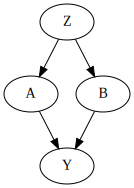

In [3]:
dot = Digraph()
dot.node("A")
dot.node("B")
dot.node("Z")
dot.node("Y")
dot.edges(["ZA", "ZB", "AY", "BY"])
dot

In [6]:
b_A = 0.25
b_B = 0.25
s_Y = 0.25
# Generate a random number
Z = random.normal(simkeys[0], (nsim,))
# Expit uses a sigmoid function to create a weight of the coin, which replaces p = 0.5 in the original documentation
A = random.bernoulli(key = simkeys[1], p = expit(Z))
B = random.bernoulli(key = simkeys[2], p = expit(Z))
# Create the Y variable that's made up of A, B, and variance Y 
Y = A * b_A + B * b_B + s_Y * random.normal(simkeys[3], (nsim,))

 # MCAR

In [8]:
A_isobs_mcar = random.bernoulli(simkeys[4], jnp.ones(A.shape)*0.8)
Aobs_mcar = jnp.where(A_isobs_mcar, A, -1)
A_obsidx_mcar = jnp.where(A_isobs_mcar)

# generate complete case arrays
Acc_mcar = Aobs_mcar[A_obsidx_mcar]
Bcc_mcar = B[A_obsidx_mcar]
Ycc_mcar = Y[A_obsidx_mcar]

 ### Complete Case Model

In [9]:
def ccmodel(A, B, Y):
    ntotal = A.shape[0]
    # get parameters of outcome model
    b_A = sample("b_A", dist.Normal(0, 2.5))
    b_B = sample("b_B", dist.Normal(0, 2.5))
    s_Y = sample("s_Y", dist.HalfCauchy(2.5))

    with numpyro.plate("obs", ntotal):
        ### outcome model
        eta_Y = b_A * A + b_B * B
        sample("obs_Y", dist.Normal(eta_Y, s_Y), obs=Y)

In [10]:
cckernel = NUTS(ccmodel)
ccmcmc = MCMC(cckernel, num_warmup=250, num_samples=750)
ccmcmc.run(mcmc_key, Acc_mcar, Bcc_mcar, Ycc_mcar)
ccmcmc.print_summary()

sample: 100%|██████████| 1000/1000 [00:06<00:00, 144.65it/s, 7 steps of size 4.52e-01. acc. prob=0.92]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
       b_A      0.25      0.01      0.25      0.24      0.26    557.18      1.00
       b_B      0.25      0.01      0.25      0.24      0.26    487.23      1.00
       s_Y      0.25      0.00      0.25      0.25      0.26    428.99      1.00

Number of divergences: 0


 ### Implicit Missingness Model with imputation from B

In [11]:
def impmodel(A, B, Y):
    ntotal = A.shape[0]
    A_isobs = A >= 0

    # get parameters of imputation model
    mu_A = sample("mu_A", dist.Normal(0, 2.5))
    b_B_A = sample("b_B_A", dist.Normal(0, 2.5))

    # get parameters of outcome model
    b_A = sample("b_A", dist.Normal(0, 2.5))
    b_B = sample("b_B", dist.Normal(0, 2.5))
    s_Y = sample("s_Y", dist.HalfCauchy(2.5))

    with numpyro.plate("obs", ntotal):
        ### imputation model
        # get linear predictor for missing values
        eta_A = mu_A + B * b_B_A

        # sample imputation values for A
        # mask out to not add log_prob to total likelihood right now
        Aimp = sample(
            "A",
            dist.Bernoulli(logits=eta_A).mask(False),
            infer={"enumerate": "parallel"},
        )

        # 'manually' calculate the log_prob
        log_prob = dist.Bernoulli(logits=eta_A).log_prob(Aimp)

        # cancel out enumerated values that are not equal to observed values
        log_prob = jnp.where(A_isobs & (Aimp != A), -inf, log_prob)

        # add to total likelihood for sampler
        numpyro.factor("A_obs", log_prob)

        ### outcome model
        eta_Y = b_A * Aimp + b_B * B
        sample("obs_Y", dist.Normal(eta_Y, s_Y), obs=Y)

In [13]:
impkernel = NUTS(impmodel)
impmcmc = MCMC(impkernel, num_warmup=250, num_samples=750)
impmcmc.run(mcmc_key, Aobs_mcar, B, Y)
impmcmc.print_summary()

sample: 100%|██████████| 1000/1000 [00:09<00:00, 107.44it/s, 7 steps of size 4.93e-01. acc. prob=0.89]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
       b_A      0.25      0.01      0.25      0.24      0.26    822.70      1.00
       b_B      0.25      0.01      0.25      0.24      0.26    705.92      1.00
     b_B_A      0.70      0.06      0.70      0.61      0.81    402.47      1.00
      mu_A     -0.34      0.04     -0.34     -0.41     -0.27    326.23      1.00
       s_Y      0.25      0.00      0.25      0.25      0.26    816.20      1.00

Number of divergences: 0


 # MAR

 ## MAR conditional on outcome

 According to Rubin's classic definitions there are 3 distinct missing data mechanisms:

 1. missing completely at random (MCAR)
 2. missing at random, conditional on observed data (MAR)
 3. missing not at random, even after conditioning on observed data (MNAR)

 Missing data mechanisms 1. and 2. are 'easy' to handle as they depend on observed data only.
 Mechanism 3. (MNAR) is trickier as it depends on data that is not observed, but may still be relevant to the outcome you are modeling (see below for a concrete example).

 First we will generate missing values in A, conditional on the value of Y (thus it is a MAR mechanism).

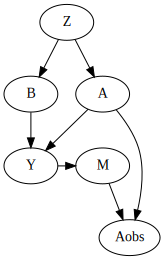

In [14]:
dot_mnar_y = Digraph()
with dot_mnar_y.subgraph() as s:
    s.attr(rank="same")
    s.node("Y")
    s.node("M")
dot_mnar_y.node("A")
dot_mnar_y.node("B")
dot_mnar_y.node("Z")
dot_mnar_y.node("M")
dot_mnar_y.node('Aobs')
dot_mnar_y.edges(["YM", "ZA", "ZB", "AY", "BY",('M','Aobs'),('A','Aobs')])
dot_mnar_y

 This graph depicts the data generating mechanism, where Y is the only cause of missingness in A, denoted M. This means that the missingness in M is random, conditional on Y.

 As an example consider this simplified scenario:

 - A represents a history of heart illness
 - B represents the age of a patient
 - Y represents whether or not the patient will visit the general practitioner

 A general practitioner wants to find out why patients that are assigned to her clinic will visit the clinic or not. She thinks that having a history of heart illness and age are potential causes of doctor visits. Data on patient ages are available through their registration forms, but information on prior heart illness may be available only after they have visited the clinic. This makes the missingness in A (history of heart disease), dependent on the outcome (visiting the clinic).

In [15]:
A_isobs = random.bernoulli(simkeys[4], expit(3 * (Y - Y.mean())))
Aobs = jnp.where(A_isobs, A, -1)
A_obsidx = jnp.where(A_isobs)

# generate complete case arrays
Acc = Aobs[A_obsidx]
Bcc = B[A_obsidx]
Ycc = Y[A_obsidx]

 We will evaluate 2 approaches:

 1. complete case analysis (which will lead to biased inferences)
 2. with imputation (conditional on B)

 Note that explicitly including Y in the imputation model for A is unneccesary.
 The sampled imputations for A will condition on Y indirectly as the likelihood of Y is conditional on A.
 So values of A that give high likelihood to Y will be sampled more often than other values.

 ### Complete Case Model

In [16]:
def ccmodel(A, B, Y):
    ntotal = A.shape[0]
    # get parameters of outcome model
    b_A = sample("b_A", dist.Normal(0, 2.5))
    b_B = sample("b_B", dist.Normal(0, 2.5))
    s_Y = sample("s_Y", dist.HalfCauchy(2.5))

    with numpyro.plate("obs", ntotal):
        ### outcome model
        eta_Y = b_A * A + b_B * B
        sample("obs_Y", dist.Normal(eta_Y, s_Y), obs=Y)

In [17]:
cckernel = NUTS(ccmodel)
ccmcmc = MCMC(cckernel, num_warmup=250, num_samples=750)
ccmcmc.run(mcmc_key, Acc, Bcc, Ycc)
ccmcmc.print_summary()

sample: 100%|██████████| 1000/1000 [00:05<00:00, 172.50it/s, 7 steps of size 4.96e-01. acc. prob=0.91]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
       b_A      0.30      0.01      0.30      0.28      0.31    492.84      1.02
       b_B      0.28      0.01      0.28      0.27      0.29    445.01      1.01
       s_Y      0.25      0.00      0.25      0.24      0.25    390.18      1.00

Number of divergences: 0


 ### Imputation Model
all A are imputed conditioned on the value of B

In [26]:
impkernel = NUTS(impmodel)
impmcmc = MCMC(impkernel, num_warmup=250, num_samples=750)
impmcmc.run(mcmc_key, Aobs, B, Y)
impmcmc.print_summary()

sample: 100%|██████████| 1000/1000 [00:08<00:00, 113.95it/s, 7 steps of size 4.29e-01. acc. prob=0.92]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
       b_A      0.25      0.01      0.25      0.24      0.26    536.77      1.01
       b_B      0.25      0.01      0.25      0.24      0.26    552.32      1.00
     b_B_A      0.75      0.08      0.75      0.64      0.89    239.20      1.00
      mu_A     -0.39      0.06     -0.40     -0.48     -0.30    238.77      1.00
       s_Y      0.25      0.00      0.25      0.25      0.26    750.67      1.00

Number of divergences: 0


 As we can see, when data are missing conditionally on Y, imputation leads to consistent estimation of the parameter of interest (b_A and b_B).

 ## MAR conditional on Covariate B
for additional testing, lets make the missingness in A conditional on B

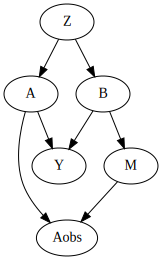

In [27]:
dot_mnar_y = Digraph()
with dot_mnar_y.subgraph() as s:
    s.attr(rank="same")
    s.node("Y")
    s.node("M")
dot_mnar_y.node("A")
dot_mnar_y.node("B")
dot_mnar_y.node("Z")
dot_mnar_y.node("M")
dot_mnar_y.node("Aobs")
dot_mnar_y.edges(["BM", "ZA", "ZB", "AY", "BY",("M","Aobs"),("A","Aobs")])
dot_mnar_y

 ### Missingness Conditioned on B Setup
 here the missingness mask depends on B. If B is 1 there is a .2 chance of being observered, if B is 0 there is a .9 chance of A being observered.

In [29]:
A_isobs_condB = random.bernoulli(simkeys[5], 0.9 - 0.8 * B)
Aobs_condB = jnp.where(A_isobs_condB, A, -1)
A_obsidx_condB = jnp.where(Aobs_condB)

calculated missingness fraction for missingness conditional on B

In [30]:
jnp.mean(A_isobs_condB)

DeviceArray(0.4978, dtype=float32)

generate complete case arrays, all rows with any missind data are dropped

In [31]:
Acc_cond = Aobs_condB[A_obsidx_condB]
Bcc_cond = B[A_obsidx_condB]
Ycc_cond = Y[A_obsidx_condB]

 ### Complete Case Model

In [32]:
cckernel = NUTS(ccmodel)
ccmcmc = MCMC(cckernel, num_warmup=250, num_samples=750)
ccmcmc.run(mcmc_key, Acc_cond, Bcc_cond, Ycc_cond)
ccmcmc.print_summary()

sample: 100%|██████████| 1000/1000 [00:04<00:00, 206.86it/s, 7 steps of size 3.64e-01. acc. prob=0.93]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
       b_A      0.14      0.01      0.14      0.13      0.15    450.67      1.00
       b_B      0.53      0.01      0.53      0.51      0.54    456.38      1.00
       s_Y      0.29      0.00      0.29      0.28      0.29    240.35      1.00

Number of divergences: 0


 ### Implicit Missingness Model
 Here since since no missing model is specified, the imputation method implies that MAR missingness

In [33]:
impkernel = NUTS(impmodel)
impmcmc = MCMC(impkernel, num_warmup=250, num_samples=750)
impmcmc.run(mcmc_key, Aobs_condB, B, Y)
impmcmc.print_summary()

sample: 100%|██████████| 1000/1000 [00:07<00:00, 129.50it/s, 7 steps of size 3.97e-01. acc. prob=0.92]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
       b_A      0.25      0.01      0.25      0.24      0.26    851.93      1.00
       b_B      0.25      0.01      0.25      0.24      0.27    458.70      1.00
     b_B_A      0.64      0.12      0.64      0.43      0.83    297.26      1.00
      mu_A     -0.36      0.04     -0.36     -0.42     -0.29    492.23      1.00
       s_Y      0.25      0.00      0.25      0.25      0.25    742.92      1.00

Number of divergences: 0


 # MNAR
 ## MNAR conditional on covariate

 When data are missing conditional on unobserved data, things get more tricky.
 Here we will generate missing values in A, conditional on the value of A itself (missing not at random (MNAR), but missing at random conditional on A).

 As an example consider patients who have cancer:

 - A represents weight loss
 - B represents age
 - Y represents overall survival time

 Both A and B can be related to survival time in cancer patients. For patients who have extreme weight loss, it is more likely that this will be noted by the doctor and registered in the electronic health record. For patients with no weight loss or little weight loss, it may be that the doctor forgets to ask about it and therefore does not register it in the records.

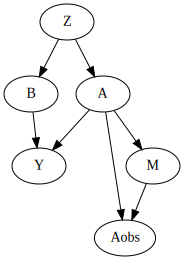

In [34]:
dot_mnar_x = Digraph()
with dot_mnar_y.subgraph() as s:
    s.attr(rank="same")
    s.node("A")
    s.node("M")
dot_mnar_x.node("B")
dot_mnar_x.node("Z")
dot_mnar_x.node("Y")
dot_mnar_x.node("Aobs")
dot_mnar_x.edges(["AM", "ZA", "ZB", "AY", "BY",('M','Aobs'), ('A', 'Aobs')])
dot_mnar_x

 ### Missingness Conditioned on A Setup

In [35]:
A_isobs = random.bernoulli(simkeys[5], 0.9 - 0.8 * A)
Aobs = jnp.where(A_isobs, A, -1)
A_obsidx = jnp.where(A_isobs)

generate complete case arrays

In [36]:
Acc = Aobs[A_obsidx]
Bcc = B[A_obsidx]
Ycc = Y[A_obsidx]

 ### Run Complete Case Model on MNAR data

In [37]:
cckernel = NUTS(ccmodel)
ccmcmc = MCMC(cckernel, num_warmup=250, num_samples=750)
ccmcmc.run(mcmc_key, Acc, Bcc, Ycc)
ccmcmc.print_summary()

sample: 100%|██████████| 1000/1000 [00:04<00:00, 239.63it/s, 7 steps of size 6.66e-01. acc. prob=0.91]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
       b_A      0.27      0.02      0.27      0.24      0.29    653.07      1.00
       b_B      0.25      0.01      0.25      0.24      0.26    838.25      1.00
       s_Y      0.25      0.00      0.25      0.24      0.25    431.83      1.00

Number of divergences: 0


 ### Run Implicit Missingness Model on MNAR data
 here MAR is assumed by not specifying a missingness model

In [38]:
impkernel = NUTS(impmodel)
impmcmc = MCMC(impkernel, num_warmup=250, num_samples=750)
impmcmc.run(mcmc_key, Aobs, B, Y)
impmcmc.print_summary()

sample: 100%|██████████| 1000/1000 [00:06<00:00, 155.44it/s, 3 steps of size 5.72e-01. acc. prob=0.88]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
       b_A      0.34      0.01      0.34      0.32      0.36    757.29      1.00
       b_B      0.33      0.01      0.33      0.32      0.34    808.49      1.00
     b_B_A      0.33      0.11      0.33      0.15      0.50    283.85      1.01
      mu_A     -1.82      0.08     -1.81     -1.96     -1.69    327.37      1.01
       s_Y      0.26      0.00      0.26      0.25      0.26    688.30      1.00

Number of divergences: 0


 Perhaps surprisingly, imputing missing values when the missingness mechanism depends on the variable itself will actually lead to bias, while complete case analysis is unbiased!
 See e.g. [Bias and efficiency of multiple imputation compared with complete‐case analysis for missing covariate values](https://doi.org/10.1002/sim.3944).

 However, complete case analysis may be undesirable as well. E.g. due to leading to lower precision in estimating the parameter from B to Y, or maybe when there is an expected difference interaction between the value of A and the parameter from A to Y. To deal with this situation, an explicit model for the reason of missingness (/observation) is required. We will add one below.

 ### Run Explicit Missingness Model on MNAR and MAR data
 where the missingness mechinism is directly modeled and treated as fully MNAR

In [98]:
def impmissmodel(A, B, Y, mtype='MNAR', **kwargs):
    ntotal = A.shape[0]
    A_isobs = A >= 0

    # get parameters of imputation model
    mu_A = sample("mu_A", dist.Normal(0, 2.5), **kwargs)
    b_B_A = sample("b_B_A", dist.Normal(0, 2.5), **kwargs)

    # get parameters of outcome model
    b_A = sample("b_A", dist.Normal(0, 2.5), **kwargs)
    b_B = sample("b_B", dist.Normal(0, 2.5), **kwargs)
    s_Y = sample("s_Y", dist.HalfCauchy(2.5), **kwargs)

    # get parameter of model of missingness
    with numpyro.plate("obsmodel", 2):
        p_Aobs = sample("p_Aobs", dist.Beta(1, 1), **kwargs)

    with numpyro.plate("obs", ntotal):
        ### imputation model
        # get linear predictor for missing values
        eta_A = mu_A + B * b_B_A
        
        # sample imputation values for A
        # mask out to not add log_prob to total likelihood right now
        Aimp = sample(
            "A",
            dist.Bernoulli(logits=eta_A).mask(False),
            infer={"enumerate": "parallel"}, **kwargs
        )

        # 'manually' calculate the log_prob
        log_prob = dist.Bernoulli(logits=eta_A).log_prob(Aimp)

        # cancel out enumerated values that are not equal to observed values
        log_prob = jnp.where(A_isobs & (Aimp != A), -inf, log_prob)

        # add to total likelihood for sampler
        numpyro.factor("obs_A", log_prob)

        ### outcome model
        eta_Y = b_A * Aimp + b_B * B
        sample("obs_Y", dist.Normal(eta_Y, s_Y), obs=Y)

        M = Aimp if mtype == 'MNAR' else B
        ### missingness / observation model
        eta_Aobs = jnp.where(M, p_Aobs[0], p_Aobs[1])

In [99]:
impmisskernel = NUTS(impmissmodel)
impmissmcmc = MCMC(impmisskernel, num_warmup=250, num_samples=750)
impmissmcmc.run(mcmc_key, Aobs, B, Y, mtype='MNAR', asdfasdf=5)
impmissmcmc.print_summary()

sample: 100%|██████████| 1000/1000 [00:15<00:00, 66.28it/s, 7 steps of size 5.02e-01. acc. prob=0.89]  



                mean       std    median      5.0%     95.0%     n_eff     r_hat
       b_A      0.34      0.01      0.34      0.32      0.36    921.42      1.00
       b_B      0.33      0.01      0.33      0.32      0.35   1071.01      1.00
     b_B_A      0.33      0.11      0.33      0.15      0.51    418.33      1.00
      mu_A     -1.82      0.08     -1.81     -1.96     -1.70    524.39      1.00
 p_Aobs[0]      0.49      0.29      0.51      0.00      0.89    929.51      1.00
 p_Aobs[1]      0.51      0.30      0.52      0.05      0.95    994.33      1.00
       s_Y      0.26      0.00      0.26      0.25      0.26    922.38      1.01

Number of divergences: 0


 #### Correct Assumption on Missingness

In [46]:
impmisskernel_condB = NUTS(impmissmodel)
impmcmc_condB = MCMC(impmisskernel, num_warmup=250, num_samples=750)
impmcmc_condB.run(mcmc_key, Aobs_condB, B, Y)
impmcmc_condB.print_summary()

sample: 100%|██████████| 1000/1000 [00:13<00:00, 74.10it/s, 7 steps of size 3.79e-01. acc. prob=0.93] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
       b_A      0.25      0.01      0.25      0.24      0.26    732.74      1.00
       b_B      0.25      0.01      0.25      0.24      0.27    497.55      1.00
     b_B_A      0.65      0.12      0.65      0.45      0.85    384.33      1.00
      mu_A     -0.36      0.04     -0.35     -0.42     -0.29    487.15      1.00
 p_Aobs[0]      0.51      0.29      0.51      0.11      1.00    777.55      1.00
 p_Aobs[1]      0.47      0.29      0.48      0.00      0.88    781.59      1.00
       s_Y      0.25      0.00      0.25      0.25      0.25    592.92      1.00

Number of divergences: 0


 #### Wrong Assumption about Missingness

In [48]:
# Implicit made Explicit 
# The estmates are still biased, in exactly the same way when the model was implicit. 
impmisskernel_condB = NUTS(impmissmodel)
impmcmc_condB = MCMC(impmisskernel, num_warmup=250, num_samples=750)
impmcmc_condB.run(mcmc_key, Aobs, B, Y, )
impmcmc_condB.print_summary()

sample: 100%|██████████| 1000/1000 [00:16<00:00, 59.07it/s, 7 steps of size 5.02e-01. acc. prob=0.89]  



                mean       std    median      5.0%     95.0%     n_eff     r_hat
       b_A      0.34      0.01      0.34      0.32      0.36    921.42      1.00
       b_B      0.33      0.01      0.33      0.32      0.35   1071.01      1.00
     b_B_A      0.33      0.11      0.33      0.15      0.51    418.33      1.00
      mu_A     -1.82      0.08     -1.81     -1.96     -1.70    524.39      1.00
 p_Aobs[0]      0.49      0.29      0.51      0.00      0.89    929.51      1.00
 p_Aobs[1]      0.51      0.30      0.52      0.05      0.95    994.33      1.00
       s_Y      0.26      0.00      0.26      0.25      0.26    922.38      1.01

Number of divergences: 0


In [49]:
# Implicit made Explicit 
# The estmates are still biased, in exactly the same way when the model was implicit. 
impmisskernel_condB = NUTS(impmissmodel)
impmcmc_condB = MCMC(impmisskernel, num_warmup=250, num_samples=750)
impmcmc_condB.run(mcmc_key, Aobs, B, Y, 'MAR')
impmcmc_condB.print_summary()

sample: 100%|██████████| 1000/1000 [00:15<00:00, 65.71it/s, 7 steps of size 5.02e-01. acc. prob=0.89]  



                mean       std    median      5.0%     95.0%     n_eff     r_hat
       b_A      0.34      0.01      0.34      0.32      0.36    921.42      1.00
       b_B      0.33      0.01      0.33      0.32      0.35   1071.01      1.00
     b_B_A      0.33      0.11      0.33      0.15      0.51    418.33      1.00
      mu_A     -1.82      0.08     -1.81     -1.96     -1.70    524.39      1.00
 p_Aobs[0]      0.49      0.29      0.51      0.00      0.89    929.51      1.00
 p_Aobs[1]      0.51      0.30      0.52      0.05      0.95    994.33      1.00
       s_Y      0.26      0.00      0.26      0.25      0.26    922.38      1.01

Number of divergences: 0


 We can now estimate the parameters b_A and b_B without bias, while still utilizing all observations.
 Obviously, modeling the missingness mechanism **relies on assumptions** that need either be substantiated with prior evidence, or possibly analyzed through sensitivity analysis.

 For more reading on missing data in bayesian inference, see:

 - [Presentation Bayesian Methods for missing data (pdf)](https://www.bayes-pharma.org/Abstracts2013/slides/NickyBest_MissingData.pdf)
 - [Bayesian Approaches for Missing Not at
 Random Outcome Data: The Role of
 Identifying Restrictions (doi:10.1214/17-STS630)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6936760/)

 # Data Example

In [51]:
df = pd.read_csv('dataset.csv.zip').drop(columns='Unnamed: 83')

In [52]:
input_cols = ['ventilated_apache','apache_4a_hospital_death_prob']
input_zscore = ['d1_sysbp_min','d1_temp_min']
input_onehot = ['gcs_eyes_apache']
y_val = 'hospital_death'

sandardize continious varriables, one hot encode the catigorical, replace -1 with null where appropriate

In [53]:
df_list = [df[input_zscore].apply(lambda x: (x-x.mean())/x.std())\
    .rename(columns=lambda x:x+'_zscore'), df[input_cols]
        , pd.get_dummies(df['gcs_eyes_apache']).rename(columns = lambda x: f'gcs_eyes_apache_{int(x)}')]

In [54]:
df_in = pd.concat(df_list, axis=1)

In [55]:
df_in['apache_4a_hospital_death_prob'].replace(-1, jnp.nan, inplace=True)

 ## complete data example

 ### create complete data model

In [56]:
def ccmodel_realdata_x(X, Y):
    ntotal = X.shape[0]
    # get parameters of outcome model
    b_X = sample("b_X", dist.Normal(jnp.zeros(X.shape[1]+1),jnp.ones(X.shape[1]+1)*2.5))
    
    with numpyro.plate("obs", ntotal):
        ### outcome model
        eta_Y = (b_X[1:]*X).sum(axis=1)+b_X[0]
        sample("obs_Y", dist.Bernoulli(logits=eta_Y), obs=Y)

In [57]:
df_real_comp = pd.concat([df_in, df[y_val]], axis = 1)
df_real_comp.dropna(inplace = True)
df_real_comp = df_real_comp[df_real_comp['apache_4a_hospital_death_prob']>=0]

 check fraction of rows lost to missingness

In [58]:
df_real_comp.shape[0] / df_in.shape[0]

0.8660168133198128

In [59]:
X_real_cc = jnp.array(df_real_comp.drop(columns=y_val))
Y_real_cc = jnp.array(df_real_comp[y_val])

In [60]:
ccmcmc_real_x = NUTS(ccmodel_realdata_x)
ccmcmc_real_x = MCMC(ccmcmc_real_x, num_warmup=250, num_samples=750)
ccmcmc_real_x.run(mcmc_key, X_real_cc, Y_real_cc)
ccmcmc_real_x.print_summary()

sample: 100%|██████████| 1000/1000 [00:47<00:00, 20.85it/s, 31 steps of size 1.21e-01. acc. prob=0.93]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
    b_X[0]     -3.60      0.11     -3.59     -3.77     -3.43    139.52      1.00
    b_X[1]     -0.42      0.02     -0.42     -0.44     -0.39    680.54      1.00
    b_X[2]     -0.09      0.01     -0.09     -0.10     -0.07    721.32      1.00
    b_X[3]      0.38      0.04      0.38      0.31      0.43    403.70      1.00
    b_X[4]      5.48      0.08      5.48      5.34      5.61    465.68      1.00
    b_X[5]     -0.50      0.11     -0.50     -0.68     -0.33    150.96      1.01
    b_X[6]     -0.21      0.11     -0.20     -0.38     -0.02    156.98      1.00
    b_X[7]     -0.07      0.11     -0.08     -0.24      0.11    150.83      1.00
    b_X[8]     -0.07      0.11     -0.07     -0.23      0.10    139.25      1.00

Number of divergences: 0


get coefficient samples. Many of the inputs come from the APACHE model used for accuity evaluation in ICUs, https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5971641/. One of the inputs in the output of the model while the others are inputs. This likely explains why some of the features are seemingly protective, since they are already inplicitly included in the APACHE model output in the death prob column.

In [61]:
df_coefs = pd.DataFrame(ccmcmc_real_x.get_samples()['b_X'],columns = ['const']+list(df_in.columns))

In [63]:
df_coefs.describe()

,const,d1_sysbp_min_zscore,d1_temp_min_zscore,ventilated_apache,apache_4a_hospital_death_prob,gcs_eyes_apache_1,gcs_eyes_apache_2,gcs_eyes_apache_3,gcs_eyes_apache_4
count,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000
mean,-3.596361,-0.418941,-0.085513,0.378223,5.483343,-0.497971,-0.207232,-0.073439,-0.073443
std,0.108895,0.016003,0.010836,0.036625,0.084181,0.107499,0.113321,0.107282,0.106189
min,-3.912349,-0.466824,-0.119222,0.241544,5.237609,-0.821409,-0.645463,-0.431571,-0.443115
25%,-3.669409,-0.428748,-0.092765,0.356063,5.421003,-0.570890,-0.288083,-0.145551,-0.144659
50%,-3.592384,-0.419124,-0.085847,0.379572,5.483545,-0.502087,-0.203098,-0.080113,-0.074981
75%,-3.519486,-0.408731,-0.078943,0.401514,5.541597,-0.422584,-0.129835,-0.002101,-0.002186
max,-3.211138,-0.369452,-0.046891,0.477815,5.719167,-0.207038,0.155810,0.242961,0.252253


calculate training AUC

In [69]:
Y_real_shuffled = random.permutation(key = simkeys[6], x = Y_real_cc)
reg_comp = df_coefs.mean().values[0] + (df_coefs.mean().values[:-1]*df_real_comp.iloc[:,:-1]).sum(axis=1).values
reg_probs = 1/(1+jnp.exp(-reg_comp))

calculated train auc

In [70]:
roc_auc_score(y_true =  Y_real_cc,
              y_score = reg_probs)

0.7550046582262938

check that AUC is bad for random targets

In [71]:
roc_auc_score(y_true =  Y_real_shuffled,
              y_score = reg_probs)

0.4966132078321661

 ### create discrete imputation model for real data
 subset to just rows with complete continuous data and impute missing discrete data

In [100]:
Xcont_cols = [col for col in df_in.columns if 'gcs_eyes_apache' not in col]
Xdisc_cols = [col for col in df_in.columns if 'gcs_eyes_apache' in col]
Xcont_df = df_in[Xcont_cols].dropna()

Xcont = jnp.array(Xcont_df.values)
Xdisc = jnp.array(df_in.loc[Xcont_df.index, Xdisc_cols].values)

X_isobs = jnp.array(df_in.iloc[Xcont_df.index,-4:].max(axis=1).values)
X_obsidx = jnp.where(X_isobs)

Y_imp = jnp.array(df[df.index.isin(Xcont_df.index)][y_val].values)

In [101]:
# Earlyn: For testing things out
def impmissmodel_realdata_x(Xcont, Xdisc, Xisobs, Y):
    # Implement this: numpyro.util.format_shapes
    
    ntotal = Xcont.shape[0]
    # get parameters of outcome model
    b_X = sample("b_X", dist.Normal(jnp.zeros(Xcont.shape[1]+Xdisc.shape[1]+1)
                                        , jnp.ones(Xcont.shape[1]+Xdisc.shape[1]+1)*2.5))
    mu_X = sample("mu_X", dist.Normal(0, 2.5))
    b_Xcont_Ximp = sample("b_X_Ximp", dist.Normal(jnp.zeros((Xcont.shape[1] * Xdisc.shape[1]))
                                                 ,jnp.ones((Xcont.shape[1] * Xdisc.shape[1]))*2.5))

    with numpyro.plate("obs", size = ntotal):
        b_Xcont_Ximp_reshaped = b_Xcont_Ximp.reshape((Xcont.shape[1] , Xdisc.shape[1]))
        eta_X = mu_X + jnp.matmul(Xcont, b_Xcont_Ximp_reshaped)
        # sample imputation values for A
        # mask out to not add log_prob to total likelihood right now
        Ximp = sample("X", dist.Categorical(logits=eta_X).mask(False),
            infer={"enumerate": "parallel"})
        
        # 'manually' calculate the log_prob
        log_prob = dist.Categorical(logits=eta_X).log_prob(Ximp)
        
        # One hot encode the imputation 
        Ximp_onehot = jnp.zeros((Ximp.size, Ximp.max() + 1))
        Ximp_onehot = Ximp_onehot.at[jnp.arange(Ximp.size), Ximp].set(1)  

        # cancel out enumerated values that are not equal to observed values
        log_prob = jnp.where(Xisobs & (Ximp_onehot != Xdisc).min(axis = 1), -inf, log_prob)

        # add to total likelihood for sampler
        numpyro.factor("obs_X", log_prob)
        
        X_0 = jnp.ones((ntotal, 1))
        X_with_imp = jnp.concatenate([Xcont,Ximp_onehot], axis = 1)
        
        ### outcome model
        eta_Y = jnp.matmul(X_with_imp,b_X[1:])+b_X[0]
        sample("obs_Y", dist.Bernoulli(logits=eta_Y), obs=Y)

In [102]:
impmissmcmc_real_x_kernel = NUTS(impmissmodel_realdata_x)
impmissmcmc_real_x = MCMC(impmissmcmc_real_x_kernel, num_warmup=250, num_samples=750)
impmissmcmc_real_x.run(mcmc_key, Xcont, Xdisc, X_isobs, Y_imp)
impmissmcmc_real_x.print_summary()

ValueError: Missing a plate statement for batch dimension -1 at site 'b_X'. You can use `numpyro.util.format_shapes` utility to check shapes at all sites of your model.

In [110]:
impmissmodel_realdata_x

<function __main__.impmissmodel_realdata_x(Xcont, Xdisc, Xisobs, Y)>